---
title: "[Conditional Inference for Financial Order Routing Using Energy-Based Models](../index.qmd)"
title-block-banner: true
---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brumoema/ising-conditional-routing/blob/main/experiments/synthetic_data.ipynb)

# Conditional Routing Experiment with THRML

## Overview
This notebook implements a **conditional routing experiment** using synthetic data to evaluate the performance of **THRML** against traditional multi-armed bandit baselines in a contextual decision-making setting.

## Problem Setting
The experiment simulates an order routing scenario where an agent must select the best venue to route orders. At each step:
1. A **context** is observed (one venue's outcome is revealed for free)
2. The agent must select which **other venue** to route to
3. The agent receives a reward and updates its belief model

## Agents Compared
- **Contextual ε-Greedy**: Maintains context-specific success/count statistics with ε=0.1 exploration
- **Contextual Thompson Sampling**: Uses Beta-distributed posteriors conditioned on context
- **THRML**: Leverages an Ising model to capture correlations between venues and performs probabilistic inference using Gibbs sampling

## Scenarios
1. **IID Venues**: No correlation between venues (correlation_weight=0.0)
2. **Correlated Venues**: Venues have positive correlations (correlation_weight=0.4)
3. **Regime Shift**: Correlations exist, and venue biases change mid-experiment (step 5000)

## Context Modes
- **Fixed Context**: Always observe Venue 0's outcome as context
- **Random Context**: Randomly select which venue provides context each step

## Key Hyperparameters
| Parameter | Value | Description |
|-----------|-------|-------------|
| `n_venues` | 3 | Number of trading venues |
| `n_steps` | 10,000 | Steps per experiment run |
| `n_seeds` | 200 | Independent runs for statistical significance |
| `discount_factor` | 0.995 | Forgetting factor for non-stationary adaptation |
| `learning_rate` | 0.05 | THRML learning rate |
| `coupling_decay` | 0.995 | Decay factor for edge weights (regularization) |
| `steps_per_sample` | 4 | Gibbs sampling thinning parameter |
| `propagation_damping` | 0.3 | Mean-field signal propagation factor |

## Output
The notebook produces regret plots comparing all three agents across the three scenarios for both context modes.

In [1]:
# Install dependencies for Colab environment
# Install dependencies for Colab T4 GPU
# Note: Run this cell only on Colab
!pip install --quiet jax jaxlib
!pip install --quiet thrml
!pip install --quiet matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 6.2 MB/s eta 0:00:00


In [2]:
# Imports for JAX, THRML, and visualization
import jax
import jax.numpy as jnp
from jax import random, lax, vmap, jit
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import NamedTuple, Tuple, Optional, List, Dict
from functools import partial

# THRML imports (JAX-compatible)
from thrml import SpinNode, Block, SamplingSchedule, sample_states
from thrml.models import IsingEBM, IsingSamplingProgram, hinton_init

In [3]:
# Verify GPU availability for optimized JAX execution
print(f"JAX Backend: {jax.default_backend()}")
try:
    print(f"Devices: {jax.devices()}")
except:
    print("Warning: No GPU devices found. Running on CPU with JAX optimization.")

JAX Backend: gpu
Devices: [CudaDevice(id=0)]


In [4]:
# Configuration settings for the experiments and agents
class ExperimentConfig(NamedTuple):
    n_venues: int = 3  # Number of trading venues participating in the simulation
    n_context_venues: int = 1
    n_steps: int = 10000  # Total simulation steps per independent run
    n_seeds: int = 200
    window_size: int = 200  # Memory depth for incremental covariance tracking
    beta: float = 1.0
    n_warmup: int = 50
    n_samples: int = 100
    steps_per_sample: int = 4
    discount_factor: float = 0.995  # Exponential decay factor for adapting to non-stationary shifts
    learning_rate: float = 0.05  # Step size for bias and edge weight updates
    coupling_decay: float = 0.995
    propagation_damping: float = 0.3
    context_mode: str = "fixed"
    damp_coupling: bool = True

class ScenarioConfig(NamedTuple):
    name: str
    correlation_weight: float
    biases: jnp.ndarray
    regime_shift_step: Optional[int]
    regime_shift_biases: Optional[jnp.ndarray]

In [ ]:
class AgentState_CEG(NamedTuple):
    successes: jnp.ndarray
    counts: jnp.ndarray

class AgentState_CTS(NamedTuple):
    alphas: jnp.ndarray
    betas: jnp.ndarray

class AgentState_THRML(NamedTuple):
    biases: jnp.ndarray
    weights: jnp.ndarray
    history_buffer: jnp.ndarray
    history_ptr: jnp.ndarray
    full_history_count: jnp.ndarray
    cov_sum: jnp.ndarray
    pair_counts: jnp.ndarray


In [6]:
def thrml_init(n_venues, window_size=200):
    """
    Standardized initialization for THRML Agent State.
    Ensures memory depth is consistent across experiments.
    """
    return AgentState_THRML(
        biases=jnp.zeros(n_venues),
        weights=jnp.zeros((n_venues * (n_venues - 1)) // 2),
        history_buffer=jnp.zeros((window_size, n_venues)),
        history_ptr=jnp.array(0, dtype=jnp.int32),
        full_history_count=jnp.array(0, dtype=jnp.int32),
        cov_sum=jnp.zeros((n_venues, n_venues)),
        pair_counts=jnp.zeros((n_venues, n_venues))
)

def build_thrml_infra(n_venues, config):
    """
    Pre-calculates JAX-optimized graph structures.
    Uses a fixed program structure that clamps the first n_context_venues.
    Selection logic will permute nodes to satisfy this structure.
    """
    nodes = [SpinNode() for _ in range(n_venues)]
    edges = [(nodes[i], nodes[j]) for i in range(n_venues) for j in range(i+1, n_venues)]
    
    schedule = SamplingSchedule(
        n_warmup=config.n_warmup, 
        n_samples=config.n_samples, 
        steps_per_sample=config.steps_per_sample
    )
    
    # Static program structure for conditional selection: always clamp first K nodes
    clamped_block = Block(nodes[:config.n_context_venues])
    free_blocks = [Block([nodes[i]]) for i in range(config.n_context_venues, n_venues)]
    
    dummy_model = IsingEBM(nodes, edges, jnp.zeros(n_venues), jnp.zeros(len(edges)), jnp.array(config.beta))
    prog_conditional = IsingSamplingProgram(dummy_model, free_blocks, clamped_blocks=[clamped_block])
    
    # Static program structure for joint update: no clamped nodes
    # Note: Use serial schedule because the graph is fully connected (all-to-all).
    # Nodes must be updated sequentially to satisfy Gibbs validity.
    serial_blocks = [Block([n]) for n in nodes]
    prog_joint = IsingSamplingProgram(dummy_model, serial_blocks, clamped_blocks=[])
    
    return {
        'nodes': nodes, 
        'edges': edges, 
        'sched': schedule, 
        'prog': prog_conditional,
        'joint_prog': prog_joint,
        'full_block': [Block(nodes)]
    }

def thrml_update(state, outcomes, obs_mask, model_node_moms, model_edge_moms, 
                 discount_factor, beta, learning_rate, 
                 propagation_damping=0.3, coupling_decay=1.0, damp_coupling=True):
    """
    Perform THRML weight update with incremental covariance tracking.
    Reduces complexity from O(W*N^2) to O(N^2) per step.
    """
    n_venues = state.biases.shape[0]
    triu_idx = jnp.triu_indices(n_venues, 1)
    
    # 1. Update Biases
    J = jnp.zeros((n_venues, n_venues)).at[triu_idx].set(state.weights)
    J = J + J.T
    # Mean-Field Signal Propagation
    influence = propagation_damping * learning_rate * beta * (J @ (outcomes * obs_mask)) * (1.0 - obs_mask)
    new_biases = (state.biases * discount_factor) + (learning_rate * beta * (outcomes * obs_mask - model_node_moms * obs_mask)) + influence
    
    # 2. Incremental Covariance Update
    old_obs = state.history_buffer[state.history_ptr]
    old_present = (old_obs != 0).astype(jnp.float32)
    
    new_obs = outcomes * obs_mask
    new_present = obs_mask
    
    # Subtract old contribution, Add new contribution
    new_cov_sum = state.cov_sum - jnp.outer(old_obs, old_obs) + jnp.outer(new_obs, new_obs)
    new_pair_counts = state.pair_counts - jnp.outer(old_present, old_present) + jnp.outer(new_present, new_present)
    
    # 3. Update Buffer
    new_buffer = state.history_buffer.at[state.history_ptr].set(new_obs)
    new_ptr = (state.history_ptr + 1) % state.history_buffer.shape[0]
    new_count = jnp.minimum(state.full_history_count + 1, state.history_buffer.shape[0])
    
    # Calculate empirical correlations
    emp_cov = new_cov_sum / jnp.maximum(new_pair_counts, 1.0)
    emp = emp_cov[triu_idx]
    
    # 4. Update Weights
    pairs_observed = new_pair_counts[triu_idx] > 0
    weights_grad = (emp - model_edge_moms)
    innovation = beta * learning_rate * weights_grad
    innovation = jnp.where(damp_coupling, innovation, 0.0)
    
    new_weights = (state.weights + jnp.where(pairs_observed, innovation, 0.0)) * discount_factor * coupling_decay
    
    return AgentState_THRML(new_biases, new_weights, new_buffer, new_ptr, new_count, new_cov_sum, new_pair_counts)


In [7]:
def get_context_index(context_venues, context_outcomes, n_venues, n_context_venues):
    # Optimized Dense Mapping: Venue * 2 + Outcome
    # This matches the historical experiment
    venue_idx = context_venues[0]
    outcome_bit = (context_outcomes[0] > 0).astype(jnp.int32)
    return venue_idx * 2 + outcome_bit

In [8]:
# Contextual Epsilon Greedy agent implementation
def ceg_init(config: ExperimentConfig) -> AgentState_CEG:
    # Contexts = 2^N masks * 2^K outcome combinations
    n_contexts = config.n_venues * 2 # Dense mapping
    return AgentState_CEG(
        successes=jnp.zeros((n_contexts, config.n_venues)),
        counts=jnp.zeros((n_contexts, config.n_venues))
    )

def ceg_select(
    state: AgentState_CEG, 
    key: jax.Array, 
    context_idx: int,
    routing_mask: jnp.ndarray,
    epsilon: float = 0.1
) -> int:
    """Select venue given context, using epsilon-greedy on context-specific estimates."""
    n_venues = state.counts.shape[1]
    
    # Get estimates for this context
    context_successes = state.successes[context_idx]
    context_counts = state.counts[context_idx]
    
    means = jnp.where(
        context_counts > 0,
        context_successes / context_counts,
        0.5  # Optimistic init
    )
    best_venue = jnp.argmax(means + routing_mask)
    
    # Epsilon-greedy exploration
    k_explore, k_rand = jax.random.split(key)
    should_explore = jax.random.uniform(k_explore) < epsilon
    random_venue = random.categorical(k_rand, jnp.zeros(n_venues) + routing_mask)
    
    return jnp.where(should_explore, random_venue, best_venue)

def ceg_update(
    state: AgentState_CEG, 
    context_idx: int,
    selected_venue: int,
    outcome: jnp.ndarray,  # Outcome of selected venue
    discount_factor: float
) -> AgentState_CEG:
    """
    Update context-specific estimates for the selected venue only.
    Only the (context, selected_venue) pair is updated.
    """
    # Apply decay to all
    decayed_successes = state.successes * discount_factor
    decayed_counts = state.counts * discount_factor
    
    # Update only the (context, venue) pair
    new_counts = decayed_counts.at[context_idx, selected_venue].add(1.0)
    success_val = jnp.where(outcome > 0, 1.0, 0.0)
    new_successes = decayed_successes.at[context_idx, selected_venue].add(success_val)
    
    return AgentState_CEG(successes=new_successes, counts=new_counts)

In [ ]:
# Contextual Thompson Sampling agent implementation
def cts_init(config: ExperimentConfig, prior_alpha: float=1.0, prior_beta: float=1.0) -> AgentState_CTS:
    n_contexts = config.n_venues * 2 # Dense mapping
    return AgentState_CTS(
        alphas=jnp.ones((n_contexts, config.n_venues)) * prior_alpha,
        betas=jnp.ones((n_contexts, config.n_venues)) * prior_beta
    )

def cts_select(
    state: AgentState_CTS, 
    key: jax.Array, 
    context_idx: int,
    routing_mask: jnp.ndarray
) -> int:
    """Select venue given context, using Thompson Sampling on context-specific posteriors."""
    # Get posteriors for this context
    context_alphas = state.alphas[context_idx]
    context_betas = state.betas[context_idx]
    
    # Sample from Beta posteriors
    samples = jax.random.beta(key, context_alphas, context_betas)
    return jnp.argmax(samples + routing_mask)

def cts_update(
    state: AgentState_CTS, 
    context_idx: int,
    selected_venue: int,
    outcome: jnp.ndarray,
    discount_factor: float
) -> AgentState_CTS:
    """Update context-specific posteriors for the selected venue only."""
    # Apply decay
    decayed_alphas = state.alphas * discount_factor
    decayed_betas = state.betas * discount_factor
    
    # Update based on outcome
    alpha_inc = jnp.where(outcome > 0, 1.0, 0.0)
    beta_inc = jnp.where(outcome > 0, 0.0, 1.0)
    
    new_alphas = decayed_alphas.at[context_idx, selected_venue].add(alpha_inc)
    new_betas = decayed_betas.at[context_idx, selected_venue].add(beta_inc)
    
    return AgentState_CTS(alphas=new_alphas, betas=new_betas)

In [10]:
def thrml_select_conditional(state, key, cvs, cos, infra, config):
    n = config.n_venues
    triu_idx = jnp.triu_indices(n, 1)
    
    # 1. Create permutation mapping CVs to the first K indices
    priorities = jnp.zeros(n, dtype=jnp.int32)
    priorities = priorities.at[cvs].set(jnp.arange(config.n_context_venues))
    is_context = jnp.zeros(n, dtype=jnp.bool_).at[cvs].set(True)
    priorities = jnp.where(is_context, priorities, jnp.arange(n) + n)
    perm = jnp.argsort(priorities)
    inv_perm = jnp.argsort(perm)
    
    def get_permuted_weights():
        J = jnp.zeros((n, n)).at[triu_idx].set(state.weights)
        J = J + J.T
        J_p = J[perm][:, perm]
        return J_p[triu_idx]
        
    b_p = state.biases[perm]
    w_p = lax.cond(jnp.all(perm == jnp.arange(n)), lambda: state.weights, get_permuted_weights)
    
    # 2. Sample using the conditional program (from pre-built infra)
    model = IsingEBM(infra['nodes'], infra['edges'], b_p, w_p, jnp.array(config.beta))
    updated_prog = IsingSamplingProgram(
        model, 
        infra['prog'].gibbs_spec.superblocks, 
        infra['prog'].gibbs_spec.clamped_blocks
    )
    
    clamped_state = [(cos > 0).astype(jnp.bool_)]
    init = hinton_init(random.split(key)[0], model, updated_prog.gibbs_spec.free_blocks, ())
    samples = sample_states(random.split(key)[1], updated_prog, infra['sched'], init, clamped_state, infra['full_block'])[0]
    
    # 3. Decode results
    spins = (2 * samples.astype(jnp.float32) - 1).reshape(samples.shape[0], -1)[:, inv_perm]
    margs = jnp.mean(spins, axis=0)
    probs = (margs + 1) / 2
    
    routing_mask = jnp.zeros(n).at[cvs].set(-1e9)
    return jnp.argmax(probs + routing_mask), probs

def thrml_sample_joint(state, key, infra, config):
    """Perform UNCLAMPED sampling for unbiased weight updates."""
    model = IsingEBM(infra['nodes'], infra['edges'], state.biases, state.weights, jnp.array(config.beta))
    updated_prog = IsingSamplingProgram(
        model, 
        infra['joint_prog'].gibbs_spec.superblocks, 
        infra['joint_prog'].gibbs_spec.clamped_blocks
    )
    
    k1, k2 = random.split(key)
    init = hinton_init(k1, model, updated_prog.gibbs_spec.free_blocks, ())
    samples = sample_states(k2, updated_prog, infra['sched'], init, [], infra['full_block'])[0]
    
    spins = (2 * samples.astype(jnp.float32) - 1).reshape(samples.shape[0], -1)
    node_moms = jnp.mean(spins, axis=0)
    edge_moms = ((spins.T @ spins) / config.n_samples)[jnp.triu_indices(state.biases.shape[0], 1)]
    return node_moms, edge_moms


In [11]:
def sample_outcomes_jit(biases, correlation_weight, beta, key, sim_struct_helper):
    """
    Generates venue outcomes using an Ising model to introduce correlations. 
    """
    nodes, edges, full_block = sim_struct_helper
    
    # Weights represent correlations between all venues
    n_venues = biases.shape[0]
    n_edges = (n_venues * (n_venues - 1)) // 2
    weights = jnp.full((n_edges,), correlation_weight)
    
    model = IsingEBM(nodes, edges, biases, weights, jnp.array(beta))
    # Note: Use serial schedule for valid Gibbs sampling on fully connected graph
    serial_blocks = [Block([n]) for n in nodes]
    prog = IsingSamplingProgram(model, serial_blocks, [])
    
    # Single Gibbs sample to get the current market state
    sched = SamplingSchedule(n_warmup=100, n_samples=1, steps_per_sample=1)
    k1, k2 = random.split(key)
    init = hinton_init(k1, model, serial_blocks, ())
    
    samples = sample_states(k2, prog, sched, init, [], full_block)[0]
    
    # Return both discrete outcomes AND continuous latent scores for argmax
    # Latent score approximation: Bias + Field influence + Noise (using uniform noise for tie-breaking)
    # Since we can't easily extract internal fields, we add small noise to spins to break ties uniquely
    discrete_outcomes = 2 * samples[0].astype(jnp.float32) - 1
    
    
    # THRML-Based Oracle Definition: 
    # The 'best' venue is defined by the Local Field (gamma) as per 
    # the Ising EBM specification: gamma_i = bias_i + sum_{j != i} J_ij * s_j
    total_spin_sum = jnp.sum(discrete_outcomes)
    neighbor_influence = correlation_weight * (total_spin_sum - discrete_outcomes)
    local_field = biases + neighbor_influence
    
    # Add small tie-breaker for unique argmax
    k3 = random.split(k2)[0]
    tie_breaker = jax.random.uniform(k3, (n_venues,), minval=-1e-5, maxval=1e-5)
    
    latent_scores = local_field + tie_breaker
    
    return discrete_outcomes, latent_scores

In [12]:
def run_single_seed_experiment(
    master_seed: jax.Array,
    config: ExperimentConfig,
    scenario_config: ScenarioConfig,
    infra: Dict,
    sim_struct_helper: Tuple
) -> dict:
    
    # 2. Initialize carries
    rng = master_seed
    
    agent_ceg = ceg_init(config)
    agent_cts = cts_init(config)
    agent_thrml = thrml_init(config.n_venues, window_size=config.window_size)
    
    Carry = NamedTuple("Carry", [
        ("rng", jax.Array),
        ("agent_ceg", AgentState_CEG),
        ("agent_cts", AgentState_CTS),
        ("agent_thrml", AgentState_THRML),
    ])
    
    init_carry = Carry(rng, agent_ceg, agent_cts, agent_thrml)
    
    def step_fn(carry: Carry, step_idx: int):
        rng = carry.rng
        
        current_biases = lax.select(
            step_idx >= scenario_config.regime_shift_step if scenario_config.regime_shift_step is not None else False,
            scenario_config.regime_shift_biases if scenario_config.regime_shift_biases is not None else scenario_config.biases,
            scenario_config.biases
        )
        
        rng, k_context, k_sim, k_agents, k_update = random.split(rng, 5)
        
        outcomes, latent_scores = sample_outcomes_jit(
            current_biases, 
            scenario_config.correlation_weight, 
            config.beta,
            k_sim,
            sim_struct_helper
        )
        
        is_fixed_mode = (config.context_mode == "fixed")
        context_venues = lax.cond(
            is_fixed_mode,
            lambda: jnp.arange(config.n_context_venues),
            lambda: jax.random.permutation(k_context, jnp.arange(config.n_venues))[:config.n_context_venues]
        )
        
        # --- Oracle & Reward Calculation ---
        # 1. Global Winner Determination (Unmasked)
        # Allows Context Venue to be the winner (Outcome = +1.0)
        oracle_best_global = jnp.argmax(latent_scores)
        rewards = jnp.where(jnp.arange(config.n_venues) == oracle_best_global, 1.0, -1.0)
        
        # 2. Context Signal
        context_outcomes = rewards[context_venues]
        context_idx = get_context_index(context_venues, context_outcomes, config.n_venues, config.n_context_venues)
        
        # 3. Agent Availability Masking
        # Prevent agents from routing to the context venue
        routing_mask = jnp.zeros(config.n_venues).at[context_venues].set(-1e9)
        
        # 4. Oracle Reward Calculation (Best *Available* Venue)
        # If Global Winner was the Context Venue, the best available reward will be -1.0.
        # This results in 0 Regret (Optimal decision given constraints).
        oracle_best_available = jnp.argmax(latent_scores + routing_mask)
        oracle_reward = rewards[oracle_best_available]
        
        k_ceg, k_cts, k_thrml = random.split(k_agents, 3)
        
        act_ceg = ceg_select(carry.agent_ceg, k_ceg, context_idx, routing_mask)
        act_cts = cts_select(carry.agent_cts, k_cts, context_idx, routing_mask)
        
        # THRML Selection: Conditional (Clamped) sampling
        act_thrml, _ = thrml_select_conditional(
            carry.agent_thrml, k_thrml, 
            context_venues, context_outcomes,
            infra, config
        )
        
        # THRML Update Preparations: Unclamped (Joint) sampling
        # This ensures the model learns the TRUE market correlations, not the conditional ones.
        model_node_moms, model_edge_moms = thrml_sample_joint(carry.agent_thrml, k_update, infra, config)
        
        r_ceg = oracle_reward - rewards[act_ceg]
        r_cts = oracle_reward - rewards[act_cts]
        r_thrml = oracle_reward - rewards[act_thrml]
        
        # Note: Baselines update based on the *observed reward* (argmax result), NOT the raw Ising outcome
        next_ceg = ceg_update(carry.agent_ceg, context_idx, act_ceg, rewards[act_ceg], config.discount_factor)
        next_cts = cts_update(carry.agent_cts, context_idx, act_cts, rewards[act_cts], config.discount_factor)
        
        # THRML update: Uses the 'argmax' result as the ground truth for the selected node
        # Context nodes are clamped to the competitive winner label (context is based on rewards, not raw spins)
        obs_mask = jnp.zeros(config.n_venues).at[context_venues].set(1.0).at[act_thrml].set(1.0)
        
        # Construct the 'observed' vector for THRML training
        # Competitive Alignment: THRML learns to identify the WINNER
        training_outcomes = rewards
        observed_data = training_outcomes * obs_mask
        
        next_thrml = thrml_update(
            carry.agent_thrml, observed_data, obs_mask, 
            model_node_moms=model_node_moms, model_edge_moms=model_edge_moms,
            discount_factor=config.discount_factor, 
            beta=config.beta,
            learning_rate=config.learning_rate,
            propagation_damping=config.propagation_damping, 
            coupling_decay=config.coupling_decay,
            damp_coupling=config.damp_coupling
        )
        
        next_carry = Carry(rng, next_ceg, next_cts, next_thrml)
        regrets = jnp.array([r_ceg, r_cts, r_thrml])
        
        return next_carry, regrets

    steps = jnp.arange(config.n_steps)
    final_carry, step_regrets = lax.scan(step_fn, init_carry, steps)
    
    return {
        "Contextual ε-Greedy": jnp.cumsum(step_regrets[:, 0]),
        "Contextual Thompson Sampling": jnp.cumsum(step_regrets[:, 1]),
        "THRML": jnp.cumsum(step_regrets[:, 2]),
        # Learned Ising parameters (for generative evaluation)
        "thrml_biases": final_carry.agent_thrml.biases,
        "thrml_weights": final_carry.agent_thrml.weights
    }


In [13]:
def run_experiment_vmapped(
    config: ExperimentConfig,
    scenario: ScenarioConfig
):
    print(f"Compiling and running scenario: {scenario.name} on GPU...")
    print(f"  Context mode: {config.context_mode}")
    start_t = time.time()
    
    # Build Static Infrastructure once outside the loop
    infra = build_thrml_infra(config.n_venues, config)
    sim_struct_helper = (infra['nodes'], infra['edges'], infra['full_block'])
    
    # Create seeds
    master = random.key(42)
    seeds = random.split(master, config.n_seeds)
    
    # Partial application for static config and infra
    run_one = partial(run_single_seed_experiment, 
                    config=config, 
                    scenario_config=scenario,
                    infra=infra,
                    sim_struct_helper=sim_struct_helper)
    
    # JIT + VMAP -> The magic of JAX
    run_all = jit(vmap(run_one))
    
    # Execute
    results = run_all(seeds)
    # Ensure computation is done
    results = jax.tree_util.tree_map(lambda x: x.block_until_ready(), results)
    
    elapsed = time.time() - start_t
    print(f"Finished {config.n_seeds} seeds x {config.n_steps} steps in {elapsed:.4f}s")
    
    return results

In [14]:
def plot_all_results(all_results, context_mode: str):
    n = len(all_results)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    if n == 1: axes = [axes]
    
    for ax, (name, res) in zip(axes, all_results.items()):
        steps = jnp.arange(res['THRML'].shape[1])
        
        for agent in ['Contextual ε-Greedy', 'Contextual Thompson Sampling', 'THRML']:
            data = res[agent]  # [n_seeds, n_steps]
            mean = jnp.mean(data, axis=0)
            std = jnp.std(data, axis=0)
            
            # Prettier labels
            label = agent
            
            ax.plot(steps, mean, label=label)
            ax.fill_between(steps, mean-std, mean+std, alpha=0.2)
            
        ax.set_title(f"{name} - Context Mode: {context_mode}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Cumulative Regret")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    plt.tight_layout()
    filename = f'conditional_sor_{context_mode}_results.png'
    plt.savefig(filename)
    print(f"Saved plot to {filename}")
    plt.show()

In [15]:
# Updated Scenarios for N=3
scenarios = [
    ScenarioConfig(
        "IID Venues", 
        0.0, 
        jnp.array([0.5, 0.0, -0.5]), 
        None, None
    ),
    ScenarioConfig(
        "Correlated Venues", 
        0.4, 
        jnp.array([0.5, 0.0, -0.5]), 
        None, None
    ),
    ScenarioConfig(
        "Regime Shift", 
        0.4, 
        # Start: Venue 0 is high success, Venue 2 is low success
        jnp.array([0.5, 0.0, -0.5]), 
        5000, 
        # Shift: Venue 0 becomes the worst, Venue 2 becomes the best
        jnp.array([-0.5, 0.0, 0.5])
    )
]

CONDITIONAL ROUTING EXPERIMENT - FIXED CONTEXT (Venue 0)
Compiling and running scenario: IID Venues on GPU...
  Context mode: fixed
Finished 200 seeds x 10000 steps in 166.8043s
Compiling and running scenario: Correlated Venues on GPU...
  Context mode: fixed
Finished 200 seeds x 10000 steps in 165.9895s
Compiling and running scenario: Regime Shift on GPU...
  Context mode: fixed
Finished 200 seeds x 10000 steps in 166.8838s
Saved plot to conditional_sor_fixed_results.png


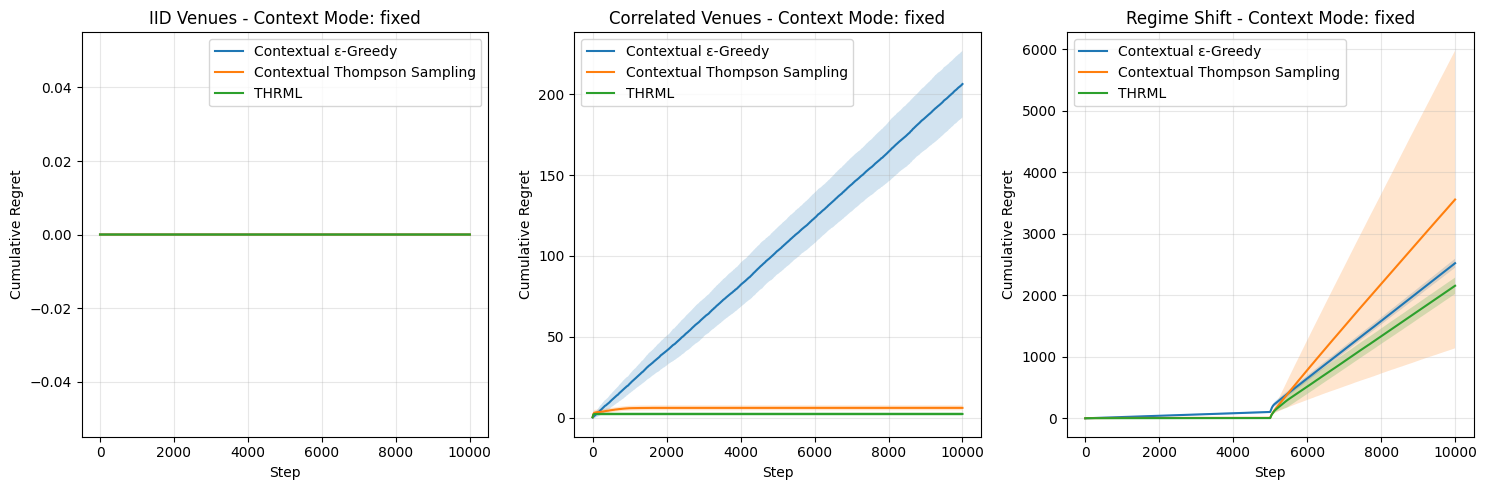

In [16]:
print("" + "="*80)
print("CONDITIONAL ROUTING EXPERIMENT - FIXED CONTEXT (Venue 0)")
print("="*80)

all_results_fixed = {}
for scenario in scenarios:
    conf = ExperimentConfig(context_mode="fixed")
    res = run_experiment_vmapped(conf, scenario)
    all_results_fixed[scenario.name] = res
    
plot_all_results(all_results_fixed, "fixed")

CONDITIONAL ROUTING EXPERIMENT - RANDOM CONTEXT
Compiling and running scenario: IID Venues on GPU...
  Context mode: random
Finished 200 seeds x 10000 steps in 168.1147s
Compiling and running scenario: Correlated Venues on GPU...
  Context mode: random
Finished 200 seeds x 10000 steps in 167.2896s
Compiling and running scenario: Regime Shift on GPU...
  Context mode: random
Finished 200 seeds x 10000 steps in 167.4150s
Saved plot to conditional_sor_random_results.png


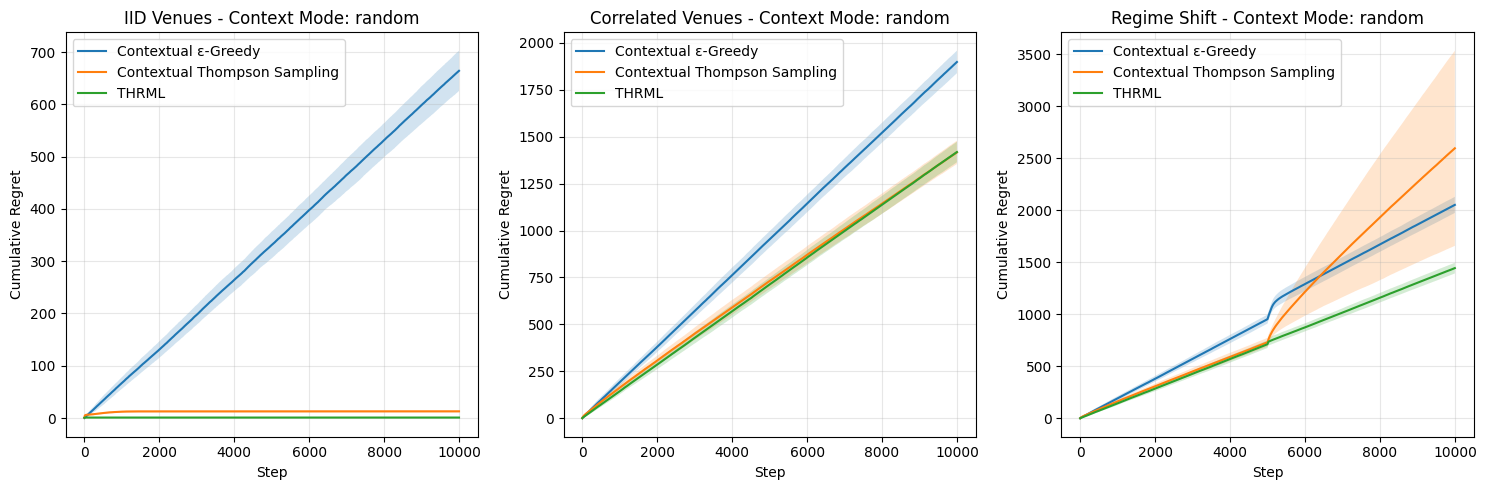

In [17]:
print("" + "="*80)
print("CONDITIONAL ROUTING EXPERIMENT - RANDOM CONTEXT")
print("="*80)

all_results_random = {}
for scenario in scenarios:
    conf = ExperimentConfig(context_mode="random")
    res = run_experiment_vmapped(conf, scenario)
    all_results_random[scenario.name] = res

plot_all_results(all_results_random, "random")

In [18]:
# Final Regret Summary Table
labels = ["Contextual ε-Greedy", "Contextual Thompson Sampling", "THRML"]
print("" + "="*80)
print(f"{ 'SCENARIO':<25} | { 'MODE':<10} | { 'ε-Greedy':<10} | {'Thompson':<10} | {'THRML':<10}")
print("-" * 80)

for mode_name, results_dict in [("fixed", all_results_fixed), ("random", all_results_random)]:
    for scenario_name, res in results_dict.items():
        row = f"{scenario_name:<25} | {mode_name:<10}"
        for agent in labels:
            final_regret = jnp.mean(res[agent][:, -1])
            row += f" | {float(final_regret):<10.4f}"
        print(row)
print("=" * 80)

SCENARIO                  | MODE       | ε-Greedy   | Thompson   | THRML     
--------------------------------------------------------------------------------
IID Venues                | fixed      | 0.0000     | 0.0000     | 0.0000    
Correlated Venues         | fixed      | 206.4000   | 5.9900     | 2.2100    
Regime Shift              | fixed      | 2520.4700  | 3555.4800  | 2154.0701 
IID Venues                | random     | 664.1200   | 12.8400    | 0.9600    
Correlated Venues         | random     | 1897.9299  | 1416.1100  | 1418.2400 
Regime Shift              | random     | 2052.6199  | 2596.8799  | 1444.4800 


## Generative Proof: Learning Raw Market Distributions

### Motivation
This section is a **completely independent experiment** that tests THRML's ability to learn the *raw* Ising data-generating process, stripped of all routing logic.

Unlike the conditional routing experiment above (where THRML only observes partial, context-masked outcomes through winner-takes-all labels) here we train a **fresh THRML agent** on the full, unmasked raw market outcomes.

### Protocol
1. **Initialize** a new THRML agent with zeroed parameters (no carryover from routing)
2. **At each step:**
   - Generate raw venue outcomes from the ground-truth Ising model (`sample_outcomes_jit`)
   - Show **all** venues' raw outcomes to THRML (`obs_mask = all ones`)
   - Update the agent's biases and weights via `thrml_update`
3. **After training**, sample from the learned model and compare against ground truth

### What This Proves
If the learned model's marginals and correlations match the ground truth, it demonstrates that THRML isn't just a routing heuristic: it is a **genuine generative model** that recovers the underlying joint distribution of market outcomes.


In [19]:
# ── Generative Proof: Training on Raw Ising Outcomes ──

def run_generative_proof_single(
    master_seed: jax.Array,
    config: ExperimentConfig,
    scenario_config: ScenarioConfig,
    infra: dict,
    sim_struct_helper: tuple,
    gt_biases: jnp.ndarray,
    n_gen_steps: int = 10000
):
    """
    Train a FRESH THRML agent on raw Ising outcomes using lax.scan.
    No routing, no winner-takes-all, no context/selection logic.

    Uses lax.scan for JAX-optimized loop compilation (matching the routing experiment pattern).
    """
    n = config.n_venues
    rng = master_seed

    agent = thrml_init(n, window_size=config.window_size)
    obs_mask = jnp.ones(n)

    Carry = NamedTuple("Carry", [
        ("rng", jax.Array),
        ("agent_thrml", AgentState_THRML),
    ])

    init_carry = Carry(rng, agent)

    def step_fn(carry: Carry, step_idx: int):
        rng = carry.rng
        rng, k_sim, k_update = random.split(rng, 3)

        outcomes, _ = sample_outcomes_jit(
            gt_biases,
            scenario_config.correlation_weight,
            config.beta,
            k_sim,
            sim_struct_helper
        )

        model_node_moms, model_edge_moms = thrml_sample_joint(
            carry.agent_thrml,
            k_update,
            infra,
            config
        )

        next_thrml = thrml_update(
            carry.agent_thrml,
            outcomes,
            obs_mask,
            model_node_moms=model_node_moms,
            model_edge_moms=model_edge_moms,
            discount_factor=config.discount_factor,
            beta=config.beta,
            learning_rate=config.learning_rate,
            propagation_damping=config.propagation_damping,
            coupling_decay=config.coupling_decay,
            damp_coupling=config.damp_coupling
        )

        next_carry = Carry(rng, next_thrml)
        return next_carry, None

    steps = jnp.arange(n_gen_steps)
    final_carry, _ = lax.scan(step_fn, init_carry, steps)

    return {
        'learned_biases': final_carry.agent_thrml.biases,
        'learned_weights': final_carry.agent_thrml.weights,
    }


def run_generative_proof_training(
    scenario: ScenarioConfig,
    config: ExperimentConfig,
    n_gen_steps: int = 10000,
    n_seeds: int = 64
):
    """
    Builds infrastructure once, then runs multi-seed training with JIT+VMAP
    to estimate variance of learned parameters.
    """
    n = config.n_venues
    print(f"\n{'─'*60}")
    print(f"Generative Proof Training: {scenario.name}")
    print(f"  n_venues={n}, n_steps={n_gen_steps}, n_seeds={n_seeds}")
    print(f"  Stationary settings: discount_factor={config.discount_factor}, coupling_decay={config.coupling_decay}")

    gt_biases = (
        scenario.regime_shift_biases
        if scenario.regime_shift_step is not None
        else scenario.biases
    )
    print(f"  GT biases={np.array(gt_biases)}, GT corr_w={scenario.correlation_weight}")
    print(f"{'─'*60}")

    infra = build_thrml_infra(n, config)
    sim_struct_helper = (infra['nodes'], infra['edges'], infra['full_block'])

    master = random.key(0)
    seeds = random.split(master, n_seeds)

    run_one = partial(
        run_generative_proof_single,
        config=config,
        scenario_config=scenario,
        infra=infra,
        sim_struct_helper=sim_struct_helper,
        gt_biases=gt_biases,
        n_gen_steps=n_gen_steps,
    )
    run_all = jit(vmap(run_one))

    start_t = time.time()
    results = run_all(seeds)
    results = jax.tree_util.tree_map(lambda x: x.block_until_ready(), results)
    elapsed = time.time() - start_t

    learned_biases = results['learned_biases']
    learned_weights = results['learned_weights']

    print(f"  Training complete in {elapsed:.2f}s")
    print(f"  Learned biases mean±std:  {np.round(np.array(jnp.mean(learned_biases, axis=0)), 4)} ± {np.round(np.array(jnp.std(learned_biases, axis=0)), 4)}")
    print(f"  Learned weights mean±std: {np.round(np.array(jnp.mean(learned_weights, axis=0)), 4)} ± {np.round(np.array(jnp.std(learned_weights, axis=0)), 4)}")
    print(f"  GT biases:                {np.round(np.array(gt_biases), 4)}")
    print(f"  GT weights:               {scenario.correlation_weight}")

    return {
        'learned_biases': learned_biases,
        'learned_weights': learned_weights,
        'gt_biases': gt_biases,
        'gt_correlation_weight': scenario.correlation_weight,
        'n_seeds': n_seeds,
    }


# ── Run Generative Proof Training ──
print("=" * 80)
print("GENERATIVE PROOF — Training THRML on Raw Ising Outcomes")
print("=" * 80)

# Stationary generative target: disable forgetting/decay attenuation.
gen_config = ExperimentConfig(discount_factor=1.0, coupling_decay=1.0)
gen_n_seeds = 64

# Exclude regime-shift from the stationary generative proof.
gen_scenarios = [s for s in scenarios if s.name != "Regime Shift"]
excluded = [s.name for s in scenarios if s.name == "Regime Shift"]
if excluded:
    print(f"Excluded from Generative Proof: {excluded}")

gen_proof_results = {}
for scenario in gen_scenarios:
    gen_proof_results[scenario.name] = run_generative_proof_training(
        scenario,
        gen_config,
        n_gen_steps=10000,
        n_seeds=gen_n_seeds,
    )

GENERATIVE PROOF — Training THRML on Raw Ising Outcomes
Excluded from Generative Proof: ['Regime Shift']

────────────────────────────────────────────────────────────
Generative Proof Training: IID Venues
  n_venues=3, n_steps=10000, n_seeds=64
  Stationary settings: discount_factor=1.0, coupling_decay=1.0
  GT biases=[ 0.5  0.  -0.5], GT corr_w=0.0
────────────────────────────────────────────────────────────
  Training complete in 85.11s
  Learned biases mean±std:  [ 0.4983 -0.0026 -0.5302] ± [0.1637 0.1635 0.1845]
  Learned weights mean±std: [0.0267 0.0106 0.0076] ± [0.0778 0.1087 0.0932]
  GT biases:                [ 0.5  0.  -0.5]
  GT weights:               0.0

────────────────────────────────────────────────────────────
Generative Proof Training: Correlated Venues
  n_venues=3, n_steps=10000, n_seeds=64
  Stationary settings: discount_factor=1.0, coupling_decay=1.0
  GT biases=[ 0.5  0.  -0.5], GT corr_w=0.4
────────────────────────────────────────────────────────────
  Training


GENERATIVE PROOF — Evaluation

Evaluating generative quality: IID Venues
  Marginal MAE (mean±std):    0.0517 ± 0.0227  | pass<0.08: True
  Correlation MAE (mean±std): 0.0662 ± 0.0299  | pass<0.08: True
  Untrained baseline MAE:     marg=0.1529, corr=0.1031

Evaluating generative quality: Correlated Venues
  Marginal MAE (mean±std):    0.0746 ± 0.0527  | pass<0.08: True
  Correlation MAE (mean±std): 0.0592 ± 0.0322  | pass<0.08: True
  Untrained baseline MAE:     marg=0.0918, corr=0.4231

Saved plot to images/generative_proof_results.png


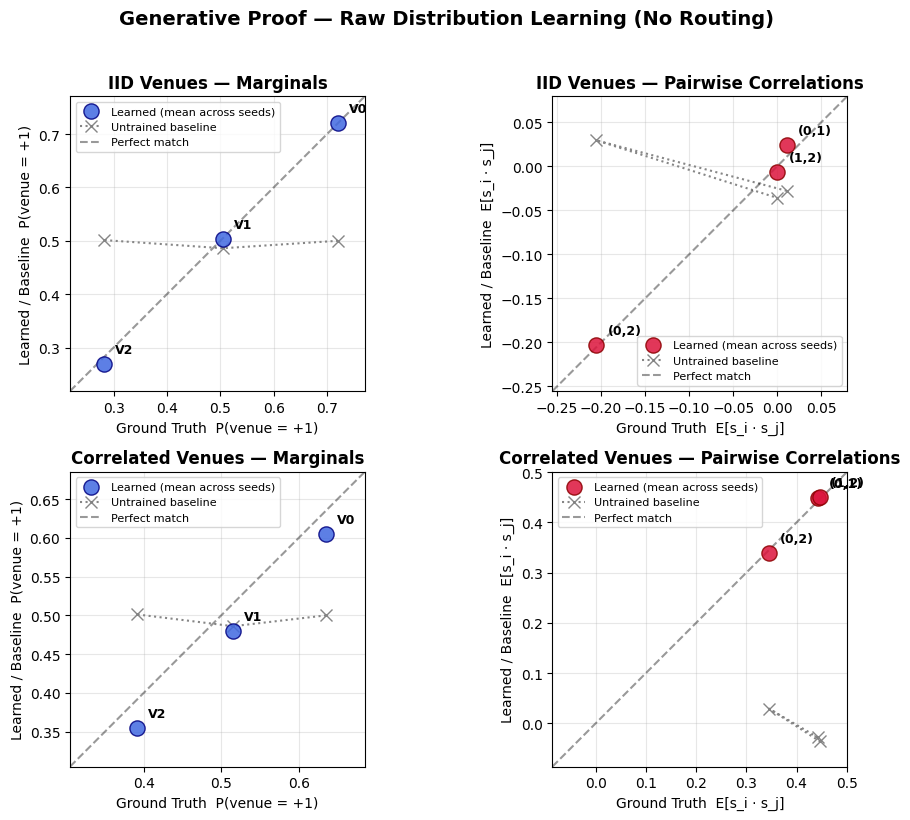


GENERATIVE PROOF — MAE SUMMARY
SCENARIO                  | MARG_MAE (mean±std)      | CORR_MAE (mean±std)      | PASS
-----------------------------------------------------------------------------------------------
IID Venues                | 0.0517±0.0227:::::::: | 0.0662±0.0299:::::::: | True
Correlated Venues         | 0.0746±0.0527:::::::: | 0.0592±0.0322:::::::: | True


In [ ]:
# ── Generative Proof: Evaluation — Sampling, Metrics & Comparison Plots ──

def run_generative_proof_evaluation(
    gen_proof_results,
    config,
    n_eval_samples=1500,
    mae_tolerance=0.08
):
    """
    Evaluate generative quality of THRML trained on raw outcomes.
    Reports mean±std MAE across seeds for marginals and pairwise correlations,
    plus pass/fail against a tolerance.
    """
    evaluations = {}
    infra = build_thrml_infra(config.n_venues, config)

    eval_sched = SamplingSchedule(
        n_warmup=200,
        n_samples=n_eval_samples,
        steps_per_sample=config.steps_per_sample
    )
    serial_blocks = [Block([n]) for n in infra['nodes']]

    def sample_model_stats(key, biases, weights):
        model = IsingEBM(
            infra['nodes'],
            infra['edges'],
            biases,
            weights,
            jnp.array(config.beta)
        )
        prog = IsingSamplingProgram(model, serial_blocks, [])
        k1, k2 = random.split(key)
        init_state = hinton_init(k1, model, serial_blocks, ())
        raw_samples = sample_states(k2, prog, eval_sched, init_state, [], infra['full_block'])[0]
        spins = (2 * raw_samples.astype(jnp.float32) - 1).reshape(-1, config.n_venues)

        marginals = (jnp.mean(spins, axis=0) + 1) / 2
        triu_idx = jnp.triu_indices(config.n_venues, 1)
        correlations = ((spins.T @ spins) / spins.shape[0])[triu_idx]
        return marginals, correlations

    for name, res in gen_proof_results.items():
        print(f"\nEvaluating generative quality: {name}")

        learned_biases = res['learned_biases']
        learned_weights = res['learned_weights']
        gt_biases = res['gt_biases']

        n_edges = (config.n_venues * (config.n_venues - 1)) // 2
        gt_weights = jnp.full((n_edges,), res['gt_correlation_weight'])
        baseline_biases = jnp.zeros_like(gt_biases)
        baseline_weights = jnp.zeros_like(gt_weights)

        key = random.key(99)
        k_gt, k_base, k_seed = random.split(key, 3)

        gt_marginals, gt_correlations = sample_model_stats(k_gt, gt_biases, gt_weights)
        baseline_marginals, baseline_correlations = sample_model_stats(k_base, baseline_biases, baseline_weights)

        seed_keys = random.split(k_seed, learned_biases.shape[0])
        learned_marginals, learned_correlations = vmap(
            lambda b, w, k: sample_model_stats(k, b, w)
        )(learned_biases, learned_weights, seed_keys)

        marg_mae_per_seed = jnp.mean(jnp.abs(learned_marginals - gt_marginals), axis=1)
        corr_mae_per_seed = jnp.mean(jnp.abs(learned_correlations - gt_correlations), axis=1)

        marg_mae_mean = float(jnp.mean(marg_mae_per_seed))
        marg_mae_std = float(jnp.std(marg_mae_per_seed))
        corr_mae_mean = float(jnp.mean(corr_mae_per_seed))
        corr_mae_std = float(jnp.std(corr_mae_per_seed))

        baseline_marg_mae = float(jnp.mean(jnp.abs(baseline_marginals - gt_marginals)))
        baseline_corr_mae = float(jnp.mean(jnp.abs(baseline_correlations - gt_correlations)))

        pass_marg = marg_mae_mean < mae_tolerance
        pass_corr = corr_mae_mean < mae_tolerance

        evaluations[name] = {
            'gt_marginals': np.array(gt_marginals),
            'gt_correlations': np.array(gt_correlations),
            'baseline_marginals': np.array(baseline_marginals),
            'baseline_correlations': np.array(baseline_correlations),
            'learned_marginals_all': np.array(learned_marginals),
            'learned_correlations_all': np.array(learned_correlations),
            'learned_marginals_mean': np.array(jnp.mean(learned_marginals, axis=0)),
            'learned_correlations_mean': np.array(jnp.mean(learned_correlations, axis=0)),
            'marg_mae_per_seed': np.array(marg_mae_per_seed),
            'corr_mae_per_seed': np.array(corr_mae_per_seed),
            'marg_mae_mean': marg_mae_mean,
            'marg_mae_std': marg_mae_std,
            'corr_mae_mean': corr_mae_mean,
            'corr_mae_std': corr_mae_std,
            'baseline_marg_mae': baseline_marg_mae,
            'baseline_corr_mae': baseline_corr_mae,
            'pass_marg': pass_marg,
            'pass_corr': pass_corr,
            'mae_tolerance': mae_tolerance,
        }

        print(f"  Marginal MAE (mean±std):    {marg_mae_mean:.4f} ± {marg_mae_std:.4f}  | pass<{mae_tolerance}: {pass_marg}")
        print(f"  Correlation MAE (mean±std): {corr_mae_mean:.4f} ± {corr_mae_std:.4f}  | pass<{mae_tolerance}: {pass_corr}")
        print(f"  Untrained baseline MAE:     marg={baseline_marg_mae:.4f}, corr={baseline_corr_mae:.4f}")

    return evaluations


def plot_generative_proof(evaluations):
    """
    For each scenario, create a 2-panel plot comparing learned mean vs ground truth,
    with an untrained (all-zeros) baseline shown as a dotted reference.
    """
    n = len(evaluations)
    fig, axes = plt.subplots(n, 2, figsize=(10, 4 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for idx, (name, data) in enumerate(evaluations.items()):
        learned_m = data['learned_marginals_mean']
        gt_m = data['gt_marginals']
        baseline_m = data['baseline_marginals']

        learned_c = data['learned_correlations_mean']
        gt_c = data['gt_correlations']
        baseline_c = data['baseline_correlations']

        ax = axes[idx, 0]
        ax.scatter(gt_m, learned_m, s=120, zorder=3,
                   c='royalblue', edgecolors='navy', alpha=0.85, label='Learned (mean across seeds)')
        ax.plot(gt_m, baseline_m, linestyle=':', marker='x', markersize=8,
                color='gray', alpha=0.95, label='Untrained baseline')
        pad = 0.05
        lo = min(gt_m.min(), learned_m.min(), baseline_m.min()) - pad
        hi = max(gt_m.max(), learned_m.max(), baseline_m.max()) + pad
        ax.plot([lo, hi], [lo, hi], 'k--', alpha=0.4, label='Perfect match')
        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        for i, (x, y) in enumerate(zip(gt_m, learned_m)):
            ax.annotate(f'V{i}', (x, y), textcoords='offset points',
                        xytext=(8, 8), fontsize=9, fontweight='bold')
        ax.set_xlabel('Ground Truth  P(venue = +1)')
        ax.set_ylabel('Learned / Baseline  P(venue = +1)')
        ax.set_title(f"{name} — Marginals", fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')

        ax = axes[idx, 1]
        ax.scatter(gt_c, learned_c, s=120, zorder=3,
                   c='crimson', edgecolors='darkred', alpha=0.85, label='Learned (mean across seeds)')
        ax.plot(gt_c, baseline_c, linestyle=':', marker='x', markersize=8,
                color='gray', alpha=0.95, label='Untrained baseline')
        lo = min(gt_c.min(), learned_c.min(), baseline_c.min()) - pad
        hi = max(gt_c.max(), learned_c.max(), baseline_c.max()) + pad
        ax.plot([lo, hi], [lo, hi], 'k--', alpha=0.4, label='Perfect match')
        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        n_venues = len(gt_m)
        edge_labels = [f'({i},{j})'
                       for i in range(n_venues)
                       for j in range(i + 1, n_venues)]
        for i, (x, y) in enumerate(zip(gt_c, learned_c)):
            ax.annotate(edge_labels[i], (x, y), textcoords='offset points',
                        xytext=(8, 8), fontsize=9, fontweight='bold')
        ax.set_xlabel('Ground Truth  E[s_i · s_j]')
        ax.set_ylabel('Learned / Baseline  E[s_i · s_j]')
        ax.set_title(f"{name} — Pairwise Correlations", fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')

    fig.suptitle(
        'Generative Proof — Raw Distribution Learning (No Routing)',
        fontsize=14,
        fontweight='bold',
        y=1.02
    )
    plt.tight_layout()
    import os
    os.makedirs('images', exist_ok=True)
    filename = 'images/generative_proof_results.png'
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    print(f"\nSaved plot to {filename}")
    plt.show()


# ── Run evaluation ──
print("\n" + "=" * 80)
print("GENERATIVE PROOF — Evaluation")
print("=" * 80)
gen_proof_eval = run_generative_proof_evaluation(
    gen_proof_results,
    gen_config,
    n_eval_samples=1500,
    mae_tolerance=0.08,
)
plot_generative_proof(gen_proof_eval)

print("\n" + "=" * 80)
print("GENERATIVE PROOF — MAE SUMMARY")
print("=" * 80)
print(f"{ 'SCENARIO':<25} | {'MARG_MAE (mean±std)':<24} | {'CORR_MAE (mean±std)':<24} | {'PASS'}")
print("-" * 95)
for scenario_name, data in gen_proof_eval.items():
    row = (
        f"{scenario_name:<25} | "
        f"{data['marg_mae_mean']:.4f}±{data['marg_mae_std']::<14.4f} | "
        f"{data['corr_mae_mean']:.4f}±{data['corr_mae_std']::<14.4f} | "
        f"{bool(data['pass_marg'] and data['pass_corr'])}"
    )
    print(row)
print("=" * 95)